In [51]:
getwd()
setwd("/liulab/galib/dlbcl_manuscript/")
library(rBCS)
library(tidyverse)
library(Seurat)
library(harmony)
library(viridis)
library(RColorBrewer)
library(Polychrome)
PurpleAndYellow()
library(ComplexHeatmap)
library(devtools)
library(presto)
library(dplyr)
library(ggplot2)
library(ggpubr)
library(readxl)
library(cluster)
set.seed(123)
source("./scripts/scplot.R")

[1] "/liulab/galib/dlbcl_manuscript"

[1] "#FF00FF" "#F400F4" "#EA00EA" "#DF00DF" "#D500D5" "#CA00CA" "#BF00BF"
 [8] "#B500B5" "#AA00AA" "#9F009F" "#950095" "#8A008A" "#800080" "#750075"
[15] "#6A006A" "#600060" "#550055" "#4A004A" "#400040" "#350035" "#2B002B"
[22] "#200020" "#150015" "#0B000B" "#000000" "#000000" "#0B0B00" "#151500"
[29] "#202000" "#2B2B00" "#353500" "#404000" "#4A4A00" "#555500" "#606000"
[36] "#6A6A00" "#757500" "#808000" "#8A8A00" "#959500" "#9F9F00" "#AAAA00"
[43] "#B5B500" "#BFBF00" "#CACA00" "#D4D400" "#DFDF00" "#EAEA00" "#F4F400"
[50] "#FFFF00"

In [93]:
cd3_pos_cd8_neg<- readRDS("./data/objects/cd3_pos_cd8_neg_final.rds")

In [94]:
legend_dot_size = unit(2,"mm")

lgd = Legend(labels = c(0, 10, 25, 50, 75, 100),
           title = "percentage",
           type = "points",
        graphics = list(
    function(x, y, w, h) grid.circle(x, y, r= sqrt(0/100) * legend_dot_size,
                                    gp = gpar(fill = "black")),
    function(x, y, w, h) grid.circle(x, y, r= sqrt(10/100) * legend_dot_size,
                                    gp = gpar(fill = "black")),
    function(x, y, w, h) grid.circle(x, y, r= sqrt(25/100) * legend_dot_size,
                                    gp = gpar(fill = "black")),
    function(x, y, w, h) grid.circle(x, y, r= sqrt(50/100) * legend_dot_size,
                                    gp = gpar(fill = "black")),
    function(x, y, w, h) grid.circle(x, y, r= sqrt(75/100) * legend_dot_size,
                                    gp = gpar(fill = "black")),
    function(x, y, w, h) grid.circle(x, y, r= sqrt(100/100) * legend_dot_size,
                                    gp = gpar(fill = "black"))            
            )
     )

## cd3_pos_cd8_neg space

In [95]:
cd3_pos_cd8_neg_genes<- read_tsv("./data/cd3_pos_cd8_neg_genes_to_plot.tsv", col_names = FALSE)  %>% 
    pull(X1)

cd3_pos_cd8_neg_genes<- str_to_title(cd3_pos_cd8_neg_genes)
cd3_pos_cd8_neg_genes<- cd3_pos_cd8_neg_genes  %>% gsub(pattern = "Aw", replacement = "AW")

cd3_pos_cd8_neg_genes[!cd3_pos_cd8_neg_genes %in% rownames(cd3_pos_cd8_neg)]

cd3_pos_cd8_neg_genes<- cd3_pos_cd8_neg_genes  %>% unique()

Rows: 92 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


character(0)

In [96]:
cluster_id<- cd3_pos_cd8_neg@meta.data  %>% arrange(seurat_clusters)  %>% distinct(new_annotation)  %>% pull(new_annotation)
cd3_pos_cd8_neg_colors<- cd3_pos_cd8_neg@meta.data  %>% arrange(seurat_clusters)  %>% distinct(HEX_code)  %>% pull(HEX_code)
names(cd3_pos_cd8_neg_colors)<- cluster_id

### All samples

#### Find optimal number of k for bidirectional clustering of the heatmap

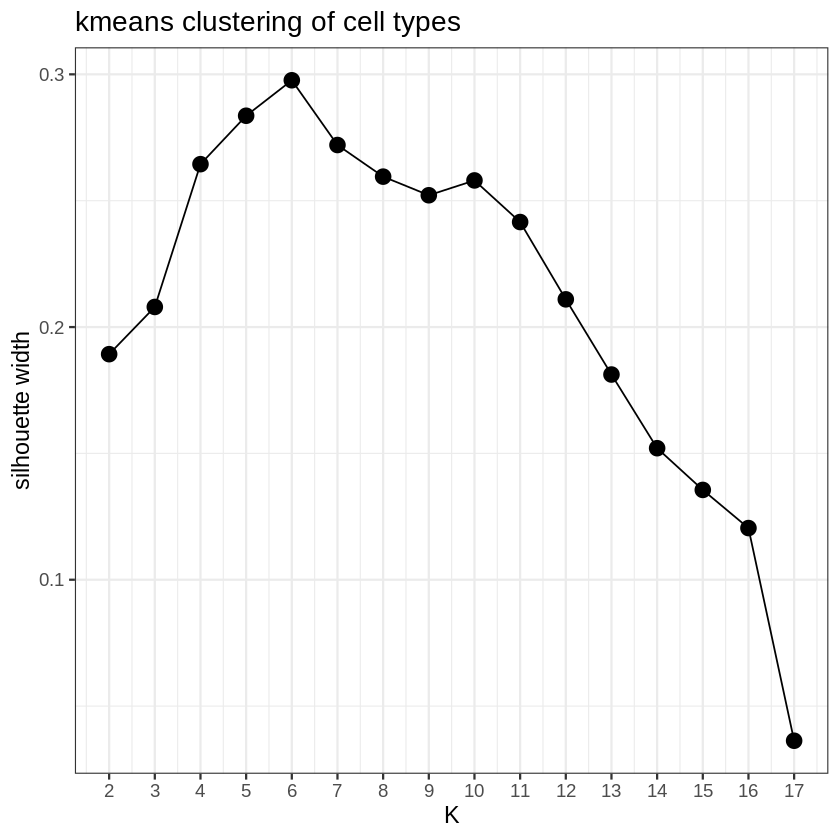

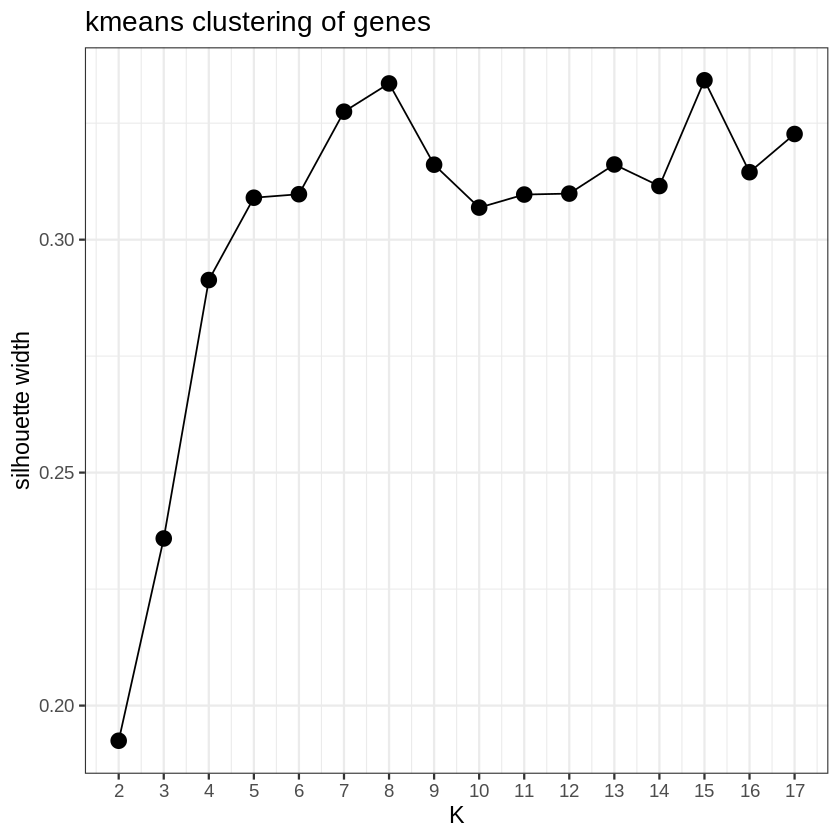

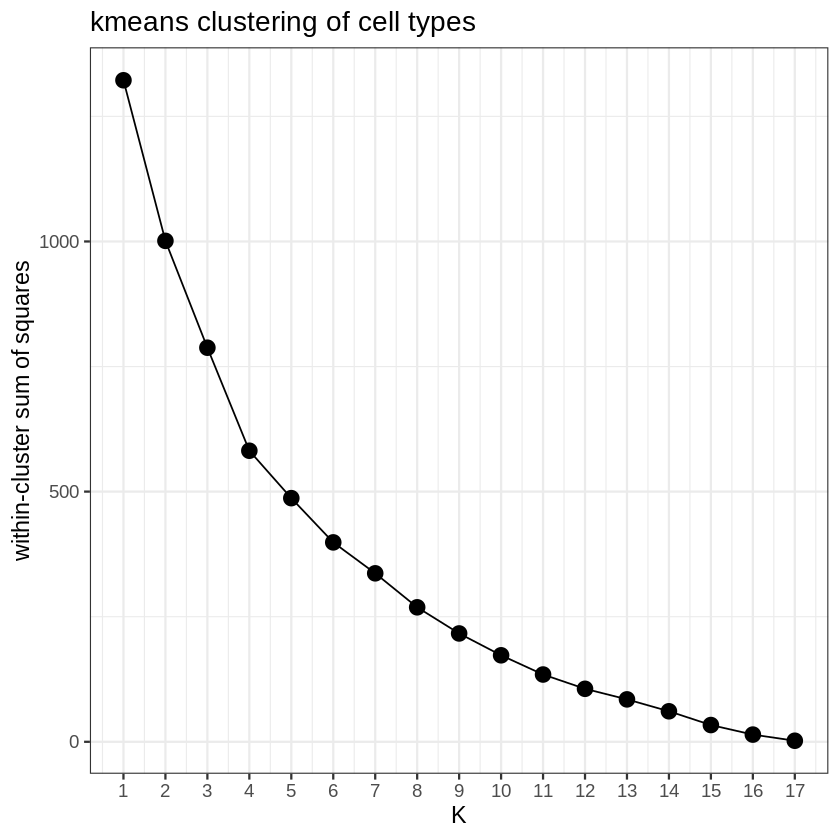

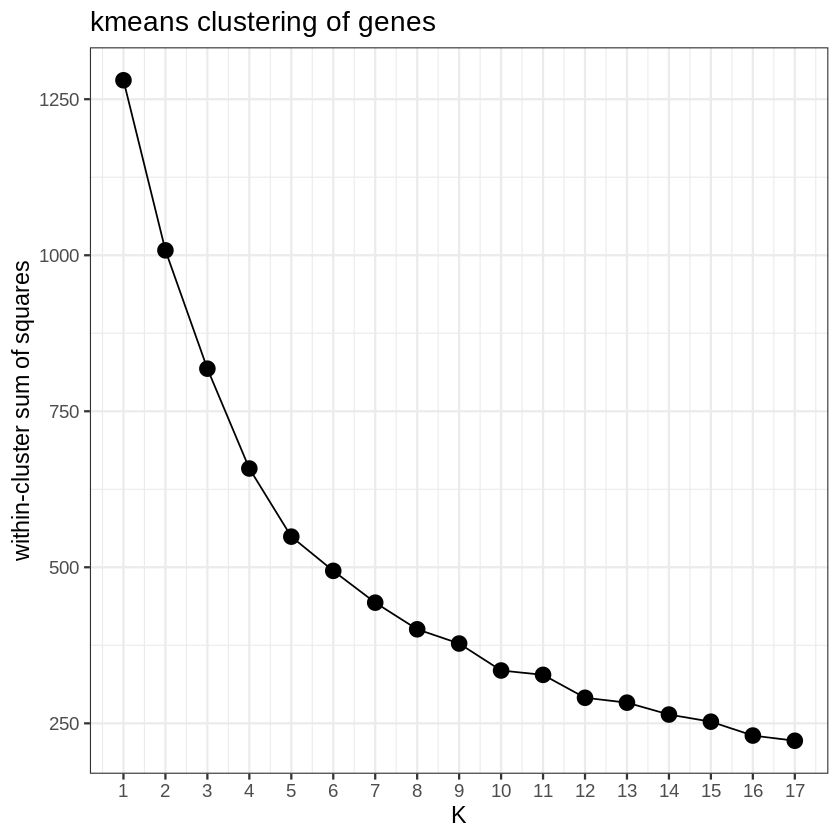

In [97]:
# Compute k-means clustering with different values of k and visualize
cd3_pos_cd8_neg_mtx<- GetMatrixFromSeurat(cd3_pos_cd8_neg, cd3_pos_cd8_neg_genes, group = "new_annotation")
nclusrers=ncol(cd3_pos_cd8_neg_mtx$exp_mat)-1

set.seed(123)
silhouette_scores <- numeric(nclusrers)

k_values = 2:nclusrers

for (k in k_values) {
  km <- kmeans(t(cd3_pos_cd8_neg_mtx$exp_mat), centers = k, nstart = 10)
  ss <- silhouette(km$cluster, dist(t(cd3_pos_cd8_neg_mtx$exp_mat)))
  silhouette_scores[k] <- mean(ss[, 3])
}

df<- data.frame(k = k_values, ss_width = silhouette_scores[c(2:nclusrers)])

df %>%
    ggplot(aes(x = k, y = ss_width)) +
    geom_line() +
    geom_point(size = 4) +
#     geom_point(aes(7, df[6,'ss_width']), size = 8, shape = 21, color='deeppink3', fill=NA) +
    theme_bw(base_size = 14) +
    scale_x_continuous(breaks = k_values) +
    labs(x = 'K', y='silhouette width', title = 'kmeans clustering of cell types')

ggsave("results/figures/5_cd3_pos_cd8_neg_kmeans_celltypes_sil_width.pdf", width = 4, height = 3)

silhouette_scores <- numeric(nclusrers)
k_values = 2:nclusrers

for (k in k_values) {
  km <- kmeans(cd3_pos_cd8_neg_mtx$exp_mat, centers = k, nstart = 10)
  ss <- silhouette(km$cluster, dist(cd3_pos_cd8_neg_mtx$exp_mat))
  silhouette_scores[k] <- mean(ss[, 3])
}

df<- data.frame(k = k_values, ss_width = silhouette_scores[c(2:nclusrers)])

df %>%
    ggplot(aes(x = k, y = ss_width)) +
    geom_line() +
    geom_point(size = 4) +
#     geom_point(aes(7, df[5,'ss_width']), size = 8, shape = 21, color='deeppink3', fill=NA) +
    theme_bw(base_size = 14) +
    scale_x_continuous(breaks = k_values) +
    labs(x = 'K', y='silhouette width', title = 'kmeans clustering of genes')

ggsave("results/figures/5_cd3_pos_cd8_neg_kmeans_genes_sil_width.pdf", width = 4, height = 3)

###
###

wss <- function(k) {
    kmeans(x = t(cd3_pos_cd8_neg_mtx$exp_mat), centers = k, nstart = 10)$tot.withinss
}

k_values <- 1:nclusrers
wss_values <- sapply(k_values, wss)

df<- data.frame(k = k_values, wss = wss_values)
df %>%
    ggplot(aes(x = k, y = wss)) +
    geom_line() +
    geom_point(size = 4) +
#     geom_point(aes(6, df[6,'wss']), size = 8, shape = 21, color='deeppink3', fill=NA) +
    theme_bw(base_size = 14) +
    scale_x_continuous(breaks = 1:nclusrers) +
    labs(x = 'K', y='within-cluster sum of squares', title = 'kmeans clustering of cell types')
ggsave("results/figures/5_cd3_pos_cd8_neg_kmeans_celltypes_elbow.pdf", width = 4, height = 3)

wss <- function(k) {
    kmeans(x = cd3_pos_cd8_neg_mtx$exp_mat, centers = k, nstart = 10)$tot.withinss
}

k_values <- 1:nclusrers
wss_values <- sapply(k_values, wss)

df<- data.frame(k = k_values, wss = wss_values)
df %>%
    ggplot(aes(x = k, y = wss)) +
    geom_line() +
    geom_point(size = 4) +
#     geom_point(aes(6, df[6,'wss']), size = 8, shape = 21, color='deeppink3', fill=NA) +
    theme_bw(base_size = 14) +
    scale_x_continuous(breaks = 1:nclusrers) +
    labs(x = 'K', y='within-cluster sum of squares', title = 'kmeans clustering of genes')

ggsave("results/figures/5_cd3_pos_cd8_neg_kmeans_genes_elbow.pdf", width = 4, height = 3)

In [98]:
cd3_pos_cd8_neg_mtx<- GetMatrixFromSeurat(cd3_pos_cd8_neg, cd3_pos_cd8_neg_genes, group = "new_annotation")


column_ha <- HeatmapAnnotation(foo = anno_text(gsub("_.*", "", cluster_id), location = 0.5, just = "center", 
                    gp = gpar(fill = setNames(cd3_pos_cd8_neg_colors, gsub("_.*", "", cluster_id)), 
                              col = "white", border = NA)), show_annotation_name = FALSE, show_legend = FALSE)

col_fun = circlize::colorRamp2(c(-2,0,2), viridis::viridis(3))

p<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx$exp_mat, 
                       percent_mat = cd3_pos_cd8_neg_mtx$percent_mat,
                       cluster_id = cluster_id,
                       column_ha = column_ha, col_fun = col_fun,
                       column_title_side = "bottom",
                       column_title = "CD3+ CD8- Space",
                       column_km = 6,
                       row_km = 8,
                       row_names_font_size = 8, 
                       legend_dot_size = unit(2, "mm"),
                       column_names_side = "top",
                       show_column_dend = FALSE,
                       show_row_dend = FALSE, 
                       cluster_columns = FALSE)

pdf("results/figures/5_cd3_pos_cd8_neg_dotplot_bidirectional_clustering.pdf", width = 7, height = 14)
set.seed(123)
ht = draw(p, annotation_legend_list = lgd)

dev.off()

png 
  2

In [99]:
cluster_id = cluster_id[column_order(ht)  %>%  unlist(use.names = FALSE)]
cluster_id = factor(cluster_id, levels = cluster_id)

cd3_pos_cd8_neg_genes = cd3_pos_cd8_neg_genes[row_order(ht)  %>%  unlist(use.names = FALSE)]
cd3_pos_cd8_neg_colors = cd3_pos_cd8_neg_colors[levels(cluster_id)]
cd3_pos_cd8_neg$new_annotation<- factor(cd3_pos_cd8_neg$new_annotation, levels = cluster_id)

cluster_id
cd3_pos_cd8_neg_genes


column_ha <- HeatmapAnnotation(foo = anno_text(gsub("_.*", "", cluster_id), location = 0.5, just = "center", 
                    gp = gpar(fill = setNames(cd3_pos_cd8_neg_colors, gsub("_.*", "", cluster_id)), 
                              col = "white", border = NA)), show_annotation_name = FALSE, show_legend = FALSE)

[1] 0_Naïve                 4b_Naïve                2_Th1/EM               
 [4] 9_NKT                   15_IFN-stimulated       1_Exhausted CTLs       
 [7] 4a_Exhausted CTLs       6_Activated CTLs        8_Other                
[10] 13_Early activated CTLs 3_Effector Tregs        5_Tfh                  
[13] 7_Follicular Tregs      10_Effector Tregs       11_Cycling Tregs       
[16] 12_Cycling              17_Cycling              24_Cycling Tregs       
18 Levels: 0_Naïve 4b_Naïve 2_Th1/EM 9_NKT ... 24_Cycling Tregs

[1] "Lgals1"   "Vim"      "Rorc"     "Ran"      "Ptma"     "Dut"     
 [7] "Mcm3"     "Gzma"     "Birc5"    "Mki67"    "Ube2c"    "Cenpa"   
[13] "Top2a"    "Pclaf"    "Mif"      "Eif5a"    "Nme1"     "Npm1"    
[19] "Il17a"    "Il10"     "Ifi27"    "Tigit"    "Izumo1r"  "Hif1a"   
[25] "Cd74"     "Il1r2"    "Pdcd1"    "Ctsb"     "Bcl6"     "Ctsz"    
[31] "Il4"      "Cd70"     "Ctla4"    "Tnfrsf18" "Tnfrsf4"  "Tnfrsf9" 
[37] "Ikzf2"    "Foxp3"    "Il2ra"    "Il1rl1"   "Gzmb"     "Havcr2"  
[43] "Ifng"     "Cd7"      "Fasl"     "Prf1"     "Ccl5"     "Nkg7"    
[49] "Gzmk"     "Eomes"    "Crtam"    "Ccl4"     "Ccl3"     "Cd3e"    
[55] "Lag3"     "Tox"      "Cd27"     "Cst7"     "AW112010" "Itgb1"   
[61] "Cd44"     "Cd40lg"   "Cd4"      "Sostdc1"  "Il21"     "Tnfsf8"  
[67] "S100a6"   "S100a4"   "Klf2"     "Ahnak"    "Tbx21"    "Crip1"   
[73] "Il7r"     "Cd8a"     "Cd8b1"    "Ifit1"    "Ifit3"    "Klrd1"   
[79] "Ncr1"     "Klrk1"    "Ly6c2"    "Klra7"    "Rpl23"    "Rps20"   
[85] "Rps8"     "Sell"     "Tcf7"     "Actn1"    "Lef1"     "Dapl1"   
[91] "Ccr7"     "Igfbp4"

### Dotplot by genotype

In [102]:
WT_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(genotype == "WT"))
cd70_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(genotype == "CD70-/-"))
single_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(genotype == "Bcl6tg/+"))
double_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(genotype == "CD70-/-;Bcl6tg/+"))

cd3_pos_cd8_neg_mtx<- GetMatrixFromSeurat2(cd3_pos_cd8_neg, cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_WT<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,WT_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_cd70<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,cd70_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_single<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,single_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_double<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,double_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_combined<- cbind(cd3_pos_cd8_neg_mtx_WT$exp_mat, cd3_pos_cd8_neg_mtx_cd70$exp_mat, 
                                 cd3_pos_cd8_neg_mtx_single$exp_mat, cd3_pos_cd8_neg_mtx_double$exp_mat)

cd3_pos_cd8_neg_combined_scaled<- t(apply(cd3_pos_cd8_neg_combined, 1, scale))
cd3_pos_cd8_neg_combined_scaled<- cd3_pos_cd8_neg_combined_scaled  %>% replace(is.na(.),0)

ncol(cd3_pos_cd8_neg_combined_scaled)
cd3_pos_cd8_neg_mtx_WT_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 1:18]
cd3_pos_cd8_neg_mtx_cd70_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 19:36]
cd3_pos_cd8_neg_mtx_single_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 37:54]
cd3_pos_cd8_neg_mtx_double_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 55:72]

colnames(cd3_pos_cd8_neg_mtx_WT_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)
colnames(cd3_pos_cd8_neg_mtx_cd70_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)
colnames(cd3_pos_cd8_neg_mtx_single_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)
colnames(cd3_pos_cd8_neg_mtx_double_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)

[1] 18
[1] 18
[1] 18
[1] 18
[1] 18


[1] 72

In [103]:
row_split = factor(rep(names(row_order(ht)), lengths(row_order(ht))), levels = names(row_order(ht)))
col_split = factor(rep(names(column_order(ht)), lengths(column_order(ht))), levels = names(column_order(ht)))



hp1<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_WT_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_WT$percent_mat, 
               col_fun = col_fun,
               cluster_id = cluster_id,              
               column_title = "WT",
               column_title_side = "bottom",
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               show_row_dend =FALSE,
               show_column_dend = FALSE,
               column_names_side = "top",
               cluster_rows = FALSE, cluster_columns = FALSE)

hp2<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_cd70_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_cd70$percent_mat, 
               col_fun = col_fun, cluster_id = cluster_id,
               column_title = "CD70-/-",
               column_title_side = "bottom",
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               column_names_side = "top", cluster_rows = FALSE, cluster_columns = FALSE)

hp3<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_single_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_single$percent_mat, 
               col_fun = col_fun, cluster_id = cluster_id,
               column_title = "Bcl6tg/+",
               column_title_side = "bottom",         
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               column_names_side = "top", cluster_rows = FALSE, cluster_columns = FALSE)

hp4<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_double_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_double$percent_mat, 
               col_fun = col_fun, cluster_id = cluster_id,
               column_title = "CD70-/-;Bcl6tg/+",
               column_title_side = "bottom",         
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               column_names_side = "top", cluster_rows = FALSE, cluster_columns = FALSE)

pdf("./results/figures/5_cd3_pos_cd8_neg_dotplot_final_annotation_by_genotype.pdf", width = 20, height = 14)
draw(hp1 + hp2 + hp3 + hp4 , annotation_legend_list = lgd, ht_gap = unit(1, "cm") )
dev.off()

png 
  2

### Dotplot by age

In [104]:
n_6mos_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(age == "6mos"))
n_14mos_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(age == "14mos"))
n_18mos_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(age == "18mos"))
sick_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(age == "sick"))

cd3_pos_cd8_neg_mtx<- GetMatrixFromSeurat2(cd3_pos_cd8_neg, cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_6mos<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,n_6mos_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_14mos<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,n_14mos_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_18mos<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,n_18mos_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_sick<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,sick_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_combined<- cbind(cd3_pos_cd8_neg_mtx_6mos$exp_mat, cd3_pos_cd8_neg_mtx_14mos$exp_mat, 
                                 cd3_pos_cd8_neg_mtx_18mos$exp_mat, cd3_pos_cd8_neg_mtx_sick$exp_mat)

cd3_pos_cd8_neg_combined_scaled<- t(apply(cd3_pos_cd8_neg_combined, 1, scale))
cd3_pos_cd8_neg_combined_scaled<- cd3_pos_cd8_neg_combined_scaled  %>% replace(is.na(.),0)


ncol(cd3_pos_cd8_neg_combined_scaled)
cd3_pos_cd8_neg_mtx_6mos_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 1:18]
cd3_pos_cd8_neg_mtx_14mos_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 19:36]
cd3_pos_cd8_neg_mtx_18mos_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 37:54]
cd3_pos_cd8_neg_mtx_sick_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 55:72]

colnames(cd3_pos_cd8_neg_mtx_6mos_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)
colnames(cd3_pos_cd8_neg_mtx_14mos_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)
colnames(cd3_pos_cd8_neg_mtx_18mos_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)
colnames(cd3_pos_cd8_neg_mtx_sick_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)

[1] 18
[1] 18
[1] 18
[1] 18
[1] 18


[1] 72

In [105]:
pdf("./results/figures/5_cd3_pos_cd8_neg_dotplot_final_annotation_by_age.pdf", width = 20, height = 14)

hp1<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_6mos_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_6mos$percent_mat,
               col_fun = col_fun, cluster_id = cluster_id,
               column_title = "6mos",
               column_title_side = "bottom",
               row_split = row_split,column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               show_row_dend =FALSE,
               show_column_dend = FALSE,
               column_names_side = "top", cluster_rows = FALSE, cluster_columns=FALSE)

hp2<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_14mos_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_14mos$percent_mat, 
               col_fun = col_fun, cluster_id = cluster_id,
               column_title = "14mos",
               column_title_side = "bottom",
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               column_names_side = "top", cluster_rows = FALSE, cluster_columns=FALSE)

hp3<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_18mos_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_18mos$percent_mat, 
               col_fun = col_fun, cluster_id = cluster_id,
               column_title = "18mos",
               column_title_side = "bottom",         
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               column_names_side = "top", cluster_rows = FALSE, cluster_columns=FALSE)

hp4<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_sick_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_sick$percent_mat, 
               col_fun = col_fun, cluster_id = cluster_id,
               column_title = "sick",
               column_title_side = "bottom",         
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               column_names_side = "top", cluster_rows = FALSE, cluster_columns=FALSE)

draw(hp1 + hp2 + hp3 + hp4 , annotation_legend_list = lgd, ht_gap = unit(1, "cm") )
dev.off()

png 
  2

### By age and genotype

- 6mos (WT, CD70-/-, Bcl6tg/+, CD70-/-;Bcl6tg/+)

In [106]:
n_6mos_WT_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(age == "6mos", genotype == "WT"))
n_6mos_cd70_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(age == "6mos", genotype == "CD70-/-"))
n_6mos_single_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(age == "6mos", genotype == "Bcl6tg/+"))
n_6mos_double_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(age == "6mos", genotype == "CD70-/-;Bcl6tg/+"))

cd3_pos_cd8_neg_mtx<- GetMatrixFromSeurat2(cd3_pos_cd8_neg, cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_6mos_WT<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,n_6mos_WT_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_6mos_cd70<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,n_6mos_cd70_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_6mos_single<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,n_6mos_single_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_6mos_double<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,n_6mos_double_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_combined<- cbind(cd3_pos_cd8_neg_mtx_6mos_WT$exp_mat,
                        cd3_pos_cd8_neg_mtx_6mos_cd70$exp_mat,
                        cd3_pos_cd8_neg_mtx_6mos_single$exp_mat,
                        cd3_pos_cd8_neg_mtx_6mos_double$exp_mat)

cd3_pos_cd8_neg_combined_scaled<- t(apply(cd3_pos_cd8_neg_combined, 1, scale))
cd3_pos_cd8_neg_combined_scaled<- cd3_pos_cd8_neg_combined_scaled  %>% replace(is.na(.),0)
# cd3_pos_cd8_neg_combined_scaled = cd3_pos_cd8_neg_combined_scaled[row_order(ht)  %>%  unlist(use.names = FALSE), ]


ncol(cd3_pos_cd8_neg_combined_scaled)
cd3_pos_cd8_neg_mtx_6mos_WT_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 1:18]
cd3_pos_cd8_neg_mtx_6mos_cd70_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 19:36]
cd3_pos_cd8_neg_mtx_6mos_single_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 37:54]
cd3_pos_cd8_neg_mtx_6mos_double_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 55:72]

colnames(cd3_pos_cd8_neg_mtx_6mos_WT_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)
colnames(cd3_pos_cd8_neg_mtx_6mos_cd70_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)
colnames(cd3_pos_cd8_neg_mtx_6mos_single_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)
colnames(cd3_pos_cd8_neg_mtx_6mos_double_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)

pdf("./results/figures/5_cd3_pos_cd8_neg_dotplot_final_annotation_6mos_by_genotype.pdf", width = 20, height = 12)

hp1<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_6mos_WT_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_6mos_WT$percent_mat, 
               col_fun = col_fun,
               cluster_id = cluster_id,              
               column_title = "6mos WT",
               column_title_side = "bottom",
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               show_row_dend =FALSE,
               show_column_dend = FALSE,
               column_names_side = "top",
               cluster_rows = FALSE, cluster_columns = FALSE)

hp2<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_6mos_cd70_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_6mos_cd70$percent_mat, 
               col_fun = col_fun, cluster_id = cluster_id,
               column_title = "6mos CD70-/-",
               column_title_side = "bottom",
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               column_names_side = "top", cluster_rows = FALSE, cluster_columns = FALSE)

hp3<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_6mos_single_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_6mos_single$percent_mat, 
               col_fun = col_fun, cluster_id = cluster_id,
               column_title = "6mos Bcl6tg/+",
               column_title_side = "bottom",         
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               column_names_side = "top", cluster_rows = FALSE, cluster_columns = FALSE)

hp4<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_6mos_double_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_6mos_double$percent_mat, 
               col_fun = col_fun, cluster_id = cluster_id,
               column_title = "6mos CD70-/-;Bcl6tg/+",
               column_title_side = "bottom",         
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               column_names_side = "top", cluster_rows = FALSE, cluster_columns = FALSE)

draw(hp1 + hp2 + hp3 + hp4 , annotation_legend_list = lgd, ht_gap = unit(1, "cm") )
dev.off()

[1] 18
[1] 18
[1] 18
[1] 18
[1] 18


[1] 72

png 
  2

- 14mos (WT, CD70-/-, Bcl6tg/+, CD70-/-;Bcl6tg/+)

In [107]:
n_14mos_WT_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(age == "14mos", genotype == "WT"))
n_14mos_cd70_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(age == "14mos", genotype == "CD70-/-"))
n_14mos_single_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(age == "14mos", genotype == "Bcl6tg/+"))
n_14mos_double_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(age == "14mos", genotype == "CD70-/-;Bcl6tg/+"))

cd3_pos_cd8_neg_mtx<- GetMatrixFromSeurat(cd3_pos_cd8_neg, cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_14mos_WT<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,n_14mos_WT_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_14mos_cd70<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,n_14mos_cd70_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_14mos_single<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,n_14mos_single_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_14mos_double<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,n_14mos_double_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_combined<- cbind(cd3_pos_cd8_neg_mtx_14mos_WT$exp_mat,
                        cd3_pos_cd8_neg_mtx_14mos_cd70$exp_mat,
                        cd3_pos_cd8_neg_mtx_14mos_single$exp_mat,
                        cd3_pos_cd8_neg_mtx_14mos_double$exp_mat)

cd3_pos_cd8_neg_combined_scaled<- t(apply(cd3_pos_cd8_neg_combined, 1, scale))
cd3_pos_cd8_neg_combined_scaled<- cd3_pos_cd8_neg_combined_scaled  %>% replace(is.na(.),0)
# cd3_pos_cd8_neg_combined_scaled = cd3_pos_cd8_neg_combined_scaled[row_order(ht)  %>%  unlist(use.names = FALSE), ]


ncol(cd3_pos_cd8_neg_combined_scaled)
cd3_pos_cd8_neg_mtx_14mos_WT_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 1:18]
cd3_pos_cd8_neg_mtx_14mos_cd70_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 19:36]
cd3_pos_cd8_neg_mtx_14mos_single_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 37:54]
cd3_pos_cd8_neg_mtx_14mos_double_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 55:72]

colnames(cd3_pos_cd8_neg_mtx_14mos_WT_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)
colnames(cd3_pos_cd8_neg_mtx_14mos_cd70_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)
colnames(cd3_pos_cd8_neg_mtx_14mos_single_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)
colnames(cd3_pos_cd8_neg_mtx_14mos_double_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)

pdf("./results/figures/5_cd3_pos_cd8_neg_dotplot_final_annotation_14mos_by_genotype.pdf", width = 20, height = 12)

hp1<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_14mos_WT_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_14mos_WT$percent_mat, 
               col_fun = col_fun,
               cluster_id = cluster_id,              
               column_title = "14mos WT",
               column_title_side = "bottom",
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               show_row_dend =FALSE,
               show_column_dend = FALSE,
               column_names_side = "top",
               cluster_rows = FALSE, cluster_columns = FALSE)

hp2<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_14mos_cd70_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_14mos_cd70$percent_mat, 
               col_fun = col_fun, cluster_id = cluster_id,
               column_title = "14mos CD70-/-",
               column_title_side = "bottom",
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               column_names_side = "top", cluster_rows = FALSE, cluster_columns = FALSE)

hp3<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_14mos_single_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_14mos_single$percent_mat, 
               col_fun = col_fun, cluster_id = cluster_id,
               column_title = "14mos Bcl6tg/+",
               column_title_side = "bottom",         
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               column_names_side = "top", cluster_rows = FALSE, cluster_columns = FALSE)

hp4<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_14mos_double_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_14mos_double$percent_mat, 
               col_fun = col_fun, cluster_id = cluster_id,
               column_title = "14mos CD70-/-;Bcl6tg/+",
               column_title_side = "bottom",         
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               column_names_side = "top", cluster_rows = FALSE, cluster_columns = FALSE)

draw(hp1 + hp2 + hp3 + hp4 , annotation_legend_list = lgd, ht_gap = unit(1, "cm") )
dev.off()

[1] 18
[1] 18
[1] 18
[1] 18


[1] 72

png 
  2

- 18mos (WT, CD70-/-, Bcl6tg/+, CD70-/-;Bcl6tg/+)

In [108]:
n_18mos_WT_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(age == "18mos", genotype == "WT"))
n_18mos_cd70_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(age == "18mos", genotype == "CD70-/-"))
n_18mos_single_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(age == "18mos", genotype == "Bcl6tg/+"))
n_18mos_double_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(age == "18mos", genotype == "CD70-/-;Bcl6tg/+"))

cd3_pos_cd8_neg_mtx<- GetMatrixFromSeurat2(cd3_pos_cd8_neg, cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_18mos_WT<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,n_18mos_WT_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_18mos_cd70<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,n_18mos_cd70_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_18mos_single<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,n_18mos_single_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_18mos_double<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,n_18mos_double_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_combined<- cbind(cd3_pos_cd8_neg_mtx_18mos_WT$exp_mat,
                        cd3_pos_cd8_neg_mtx_18mos_cd70$exp_mat,
                        cd3_pos_cd8_neg_mtx_18mos_single$exp_mat,
                        cd3_pos_cd8_neg_mtx_18mos_double$exp_mat)

cd3_pos_cd8_neg_combined_scaled<- t(apply(cd3_pos_cd8_neg_combined, 1, scale))
cd3_pos_cd8_neg_combined_scaled<- cd3_pos_cd8_neg_combined_scaled  %>% replace(is.na(.),0)
# cd3_pos_cd8_neg_combined_scaled = cd3_pos_cd8_neg_combined_scaled[row_order(ht)  %>%  unlist(use.names = FALSE), ]


ncol(cd3_pos_cd8_neg_combined_scaled)
cd3_pos_cd8_neg_mtx_18mos_WT_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 1:18]
cd3_pos_cd8_neg_mtx_18mos_cd70_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 19:36]
cd3_pos_cd8_neg_mtx_18mos_single_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 37:54]
cd3_pos_cd8_neg_mtx_18mos_double_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 55:72]

colnames(cd3_pos_cd8_neg_mtx_18mos_WT_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)
colnames(cd3_pos_cd8_neg_mtx_18mos_cd70_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)
colnames(cd3_pos_cd8_neg_mtx_18mos_single_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)
colnames(cd3_pos_cd8_neg_mtx_18mos_double_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)

pdf("./results/figures/5_cd3_pos_cd8_neg_dotplot_final_annotation_18mos_by_genotype.pdf", width = 20, height = 12)

hp1<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_18mos_WT_scaled,
               percent_mat = cd3_pos_cd8_neg_mtx_18mos_WT$percent_mat, 
               col_fun = col_fun,
               cluster_id = cluster_id,              
               column_title = "18mos WT",
               column_title_side = "bottom",
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               show_row_dend =FALSE,
               show_column_dend = FALSE,
               column_names_side = "top",
               cluster_rows = FALSE, cluster_columns = FALSE)

hp2<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_18mos_cd70_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_18mos_cd70$percent_mat, 
               col_fun = col_fun, cluster_id = cluster_id,
               column_title = "18mos CD70-/-",
               column_title_side = "bottom",
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               column_names_side = "top", cluster_rows = FALSE, cluster_columns = FALSE)

hp3<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_18mos_single_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_18mos_single$percent_mat, 
               col_fun = col_fun, cluster_id = cluster_id,
               column_title = "18mos Bcl6tg/+",
               column_title_side = "bottom",         
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               column_names_side = "top", cluster_rows = FALSE, cluster_columns = FALSE)

hp4<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_18mos_double_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_18mos_double$percent_mat, 
               col_fun = col_fun, cluster_id = cluster_id,
               column_title = "18mos CD70-/-;Bcl6tg/+",
               column_title_side = "bottom",         
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               column_names_side = "top", cluster_rows = FALSE, cluster_columns = FALSE)

draw(hp1 + hp2 + hp3 + hp4 , annotation_legend_list = lgd, ht_gap = unit(1, "cm") )
dev.off()

[1] 18
[1] 18
[1] 18
[1] 18
[1] 18


[1] 72

png 
  2

- sick (Bcl6tg/+, CD70-/-;Bcl6tg/+)

In [109]:
n_sick_single_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(age == "sick", genotype == "Bcl6tg/+"))
n_sick_double_cells<- rownames(cd3_pos_cd8_neg@meta.data  %>% filter(age == "sick", genotype == "CD70-/-;Bcl6tg/+"))

cd3_pos_cd8_neg_mtx<- GetMatrixFromSeurat2(cd3_pos_cd8_neg, cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_sick_single<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,n_sick_single_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_mtx_sick_double<- GetMatrixFromSeurat2(cd3_pos_cd8_neg[,n_sick_double_cells], cd3_pos_cd8_neg_genes, 
                                          group = "new_annotation")

cd3_pos_cd8_neg_combined<- cbind(cd3_pos_cd8_neg_mtx_sick_single$exp_mat,
                        cd3_pos_cd8_neg_mtx_sick_double$exp_mat)

cd3_pos_cd8_neg_combined_scaled<- t(apply(cd3_pos_cd8_neg_combined, 1, scale))
cd3_pos_cd8_neg_combined_scaled<- cd3_pos_cd8_neg_combined_scaled  %>% replace(is.na(.),0)
# cd3_pos_cd8_neg_combined_scaled = cd3_pos_cd8_neg_combined_scaled[row_order(ht)  %>%  unlist(use.names = FALSE), ]


ncol(cd3_pos_cd8_neg_combined_scaled)
cd3_pos_cd8_neg_mtx_sick_single_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 1:18]
cd3_pos_cd8_neg_mtx_sick_double_scaled<-  cd3_pos_cd8_neg_combined_scaled[, 19:36]

colnames(cd3_pos_cd8_neg_mtx_sick_single_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)
colnames(cd3_pos_cd8_neg_mtx_sick_double_scaled)<- colnames(cd3_pos_cd8_neg_mtx$exp_mat)

pdf("./results/figures/5_cd3_pos_cd8_neg_dotplot_final_annotation_sick_by_genotype.pdf", width = 10, height = 12)

hp1<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_sick_single_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_sick_single$percent_mat, 
               col_fun = col_fun, cluster_id = cluster_id,
               column_title = "sick Bcl6tg/+",
               column_title_side = "bottom",         
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha, 
               show_row_dend =FALSE,
               show_column_dend = FALSE,
               legend_dot_size = unit(2, "mm"),
               column_names_side = "top", cluster_rows = FALSE, cluster_columns = FALSE)

hp2<- MakeClusterDotPlot(exp_mat = cd3_pos_cd8_neg_mtx_sick_double_scaled, 
               percent_mat = cd3_pos_cd8_neg_mtx_sick_double$percent_mat, 
               col_fun = col_fun, cluster_id = cluster_id,
               column_title = "sick CD70-/-;Bcl6tg/+",
               column_title_side = "bottom",         
               row_split = row_split,
               column_split = col_split,
               row_names_font_size = 8, 
               column_ha = column_ha,
               legend_dot_size = unit(2, "mm"),
               column_names_side = "top", cluster_rows = FALSE, cluster_columns = FALSE)

draw(hp1 + hp2 , annotation_legend_list = lgd, ht_gap = unit(1, "cm") )
dev.off()

[1] 18
[1] 18
[1] 18


[1] 36

png 
  2